In [12]:
!pip install pandas sqlalchemy psycopg2 matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.5 MB/s eta 0:00:0000:0100:01m
  Created wheel for greenlet: filename=greenlet-3.0.3-cp39-cp39-macosx_10_9_x86_64.whl size=213526 sha256=46793ae7b5804f54ffaab948589e46667afb835dc17f7c9367e6f1583465c329
  Stored in directory: /Users/marvel/Library/Caches/pip/wheels/4e/b7/50/fef77b0dafc995530497e09a5123f00b1e68c9d305e9cf37e5
Successfully built greenlet


In [28]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
# Replace with your actual database credentials
db_user = 'postgres'
db_password = '10030707742'
db_host = 'localhost'
db_port = '5432'
db_name = 'Jupyter'

# Create a database connection
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


# Players Analysis Functions

# Analysis of a Player Performance

## Total Goals and Assists by Season

<p style="font-size:20px; color:green;">Important Note: Data includes all competitions.</p>



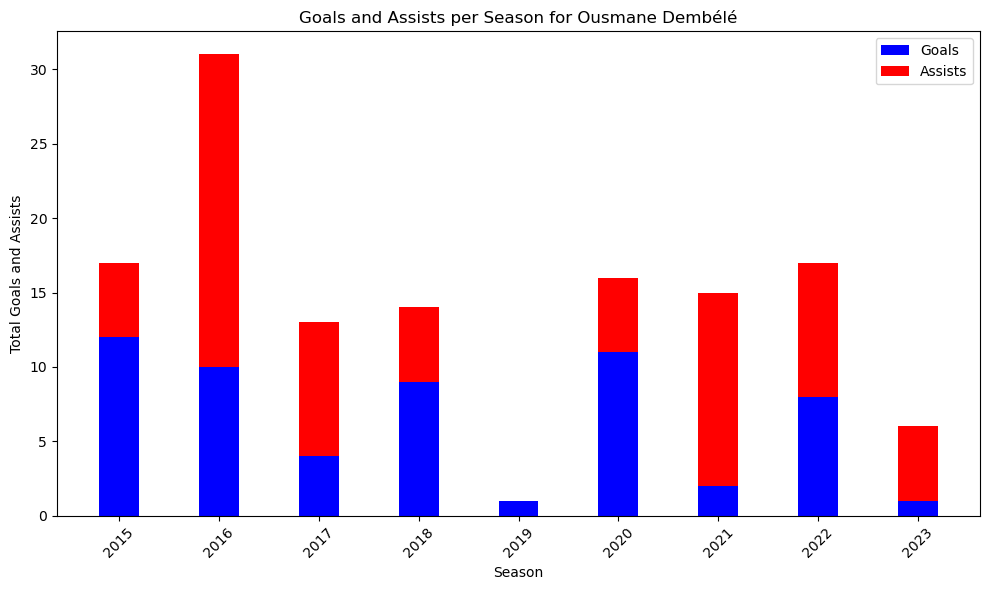

In [48]:
def plot_goals_assists_per_season(player_id):
    query = f"""
    SELECT g.season, SUM(a.goals) as total_goals, SUM(a.assists) as total_assists
    FROM Appearances a
    JOIN Games g ON a.game_id = g.game_id
    WHERE a.player_id = {player_id}
    GROUP BY g.season
    ORDER BY g.season;
    """
    df = pd.read_sql_query(query, engine)
    
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    name_df = pd.read_sql_query(name_query, engine)
    player_name = name_df['name'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    df['season'] = df['season'].astype(str)
    x = df['season']
    goals = df['total_goals']
    assists = df['total_assists']
    
    width = 0.4
    ax.bar(x, goals, width, label='Goals', color='b', align='center')
    ax.bar(x, assists, width, bottom=goals, label='Assists', color='r', align='center')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Total Goals and Assists')
    ax.set_title(f'Goals and Assists per Season for {player_name}')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#plot_goals_assists_per_season(player_id=288230)


# Display the minutes played by a player between seasons
<h4 style="font-weight:bold;">Example of usage: plot_minutes_played_by_season(player_id=288230, season_start='2020', season_end='2023')</h4>

In [42]:
def plot_minutes_played_by_season(player_id, season_start, season_end):
    # Query to get minutes played by season
    query = f"""
    SELECT g.season, SUM(a.minutes_played) as total_minutes
    FROM Appearances a
    JOIN Games g ON a.game_id = g.game_id
    WHERE a.player_id = {player_id} AND g.season BETWEEN '{season_start}' AND '{season_end}'
    GROUP BY g.season
    ORDER BY g.season;
    """
    
    # Execute the query and load the data into a DataFrame
    df = pd.read_sql_query(query, engine)
    
    # Query to get the player's full name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    
    # Execute the query and get the player's full name
    name_df = pd.read_sql_query(name_query, engine)
    player_name = name_df['name'].iloc[0]
    
    # Create the line plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df['season'] = df['season'].astype(str)  # Ensure the season is a string for better plotting
    x = df['season']
    minutes = df['total_minutes']
    
    ax.plot(x, minutes, marker='o', linestyle='-', color='b')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Total Minutes Played')
    ax.set_title(f'Total Minutes Played by Season for {player_name}')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#plot_minutes_played_by_season(player_id=288230, season_start='2020', season_end='2023')

# Average minutes played per game by a player in a season

In [41]:
def plot_minutes_played_per_game(player_id, season):
    # Query to get minutes played per game in the specified season
    query = f"""
    SELECT g.date, a.minutes_played
    FROM Appearances a
    JOIN Games g ON a.game_id = g.game_id
    WHERE a.player_id = {player_id} AND g.season = '{season}'
    ORDER BY g.date;
    """
    
    df = pd.read_sql_query(query, engine)
    
    # Query to get the player's full name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    
    # Execute the query and get the player's full name
    name_df = pd.read_sql_query(name_query, engine)
    player_name = name_df['name'].iloc[0]
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df['date'] = pd.to_datetime(df['date'])  # I'm converting it to make sure the date is in datetime format
    df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')  # converting it to string so it doesn't give me issues with displaying it on the axis 
    x = df['date_str']
    minutes = df['minutes_played']
    
    ax.bar(x, minutes, color='b')
    
    ax.set_xlabel('Game Date')
    ax.set_ylabel('Minutes Played')
    ax.set_title(f'Minutes Played per Game in {season} for {player_name}')
    ax.set_ylim(0, 90)  
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#plot_minutes_played_per_game(player_id=288230, season='2023')

# Get a player's market value through his career

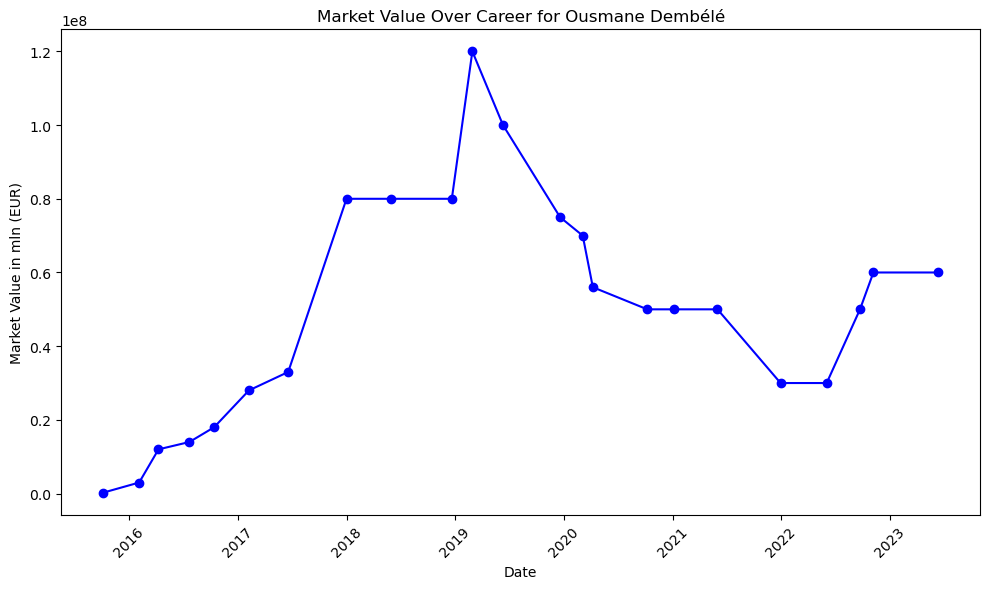

In [44]:
def plot_market_value_over_career(player_id):
    # Query to get the player's market value over time
    query = f"""
    SELECT datetime, market_value_in_eur
    FROM Player_Valuations
    WHERE player_id = {player_id}
    ORDER BY datetime;
    """
    
    # Execute the query and load the data into a DataFrame
    df = pd.read_sql_query(query, engine)
    
    # Query to get the player's full name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    
    # Execute the query and get the player's full name
    name_df = pd.read_sql_query(name_query, engine)
    player_name = name_df['name'].iloc[0]
    
    # Create the line plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure the datetime is in datetime format
    x = df['datetime']
    market_value = df['market_value_in_eur']
    
    ax.plot(x, market_value, marker='o', linestyle='-', color='b')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Market Value in mln (EUR)')
    ax.set_title(f'Market Value Over Career for {player_name}')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#plot_market_value_over_career(player_id=288230)

# Players red and yellow cards per season

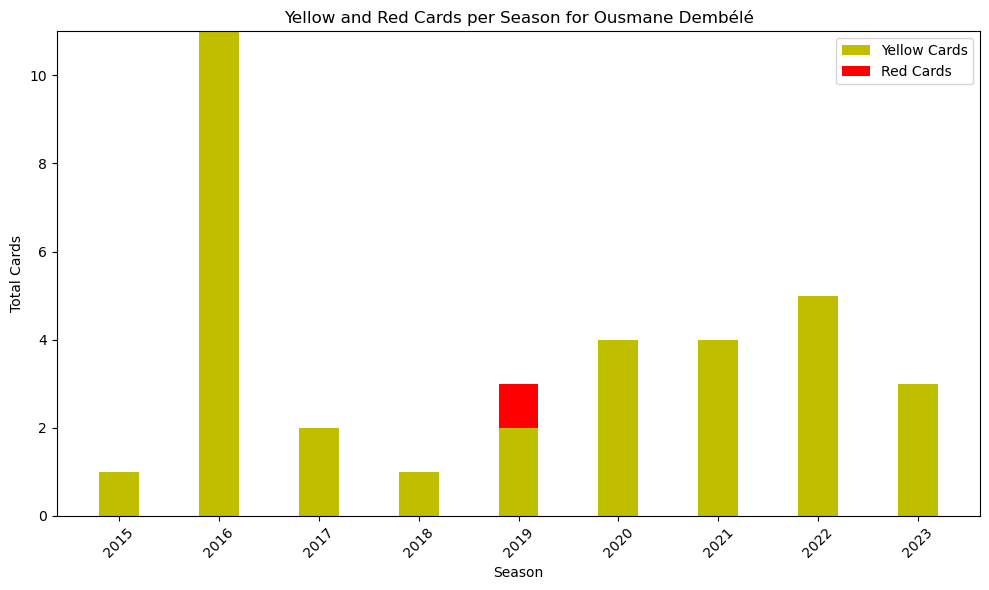

In [47]:
def plot_cards_per_season(player_id):
    query = f"""
    SELECT g.season, SUM(a.yellow_cards) as total_yellow_cards, SUM(a.red_cards) as total_red_cards
    FROM Appearances a
    JOIN Games g ON a.game_id = g.game_id
    WHERE a.player_id = {player_id}
    GROUP BY g.season
    ORDER BY g.season;
    """
    df = pd.read_sql_query(query, engine)
    
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    name_df = pd.read_sql_query(name_query, engine)
    player_name = name_df['name'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    df['season'] = df['season'].astype(str)
    x = df['season']
    yellow_cards = df['total_yellow_cards']
    red_cards = df['total_red_cards']
    
    width = 0.4
    ax.bar(x, yellow_cards, width, label='Yellow Cards', color='y', align='center')
    ax.bar(x, red_cards, width, bottom=yellow_cards, label='Red Cards', color='r', align='center')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Total Cards')
    ax.set_title(f'Yellow and Red Cards per Season for {player_name}')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
plot_cards_per_season(player_id=288230)


# Top 10 Clubs against which a player has scored the most goals

In [52]:
def plot_goals_against_top_clubs(player_id):
    top_n=10
    # Query to get goals scored by the player against each club
    query = f"""
    SELECT c.name AS club_name, SUM(a.goals) AS total_goals
    FROM Appearances a
    JOIN Games g ON a.game_id = g.game_id
    JOIN Clubs c ON g.away_club_id = c.club_id OR g.home_club_id = c.club_id
    WHERE a.player_id = {player_id}
    GROUP BY c.name
    ORDER BY total_goals DESC
    LIMIT {top_n};
    """
    
    df = pd.read_sql_query(query, engine)
    
    # Query to get the player's full name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    
    name_df = pd.read_sql_query(name_query, engine)
    player_name = name_df['name'].iloc[0]
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = df['club_name']
    goals = df['total_goals']
    
    ax.barh(x, goals, color='b')
    
    ax.set_xlabel('Total Goals')
    ax.set_ylabel('Club')
    ax.set_title(f'Top {top_n} Clubs {player_name} Scored the Most Against')
    
    plt.tight_layout()
    plt.show()

#plot_goals_against_top_clubs(player_id=288230)

# Pie chart of the percentage of goals scored at home vs goals scored awaay

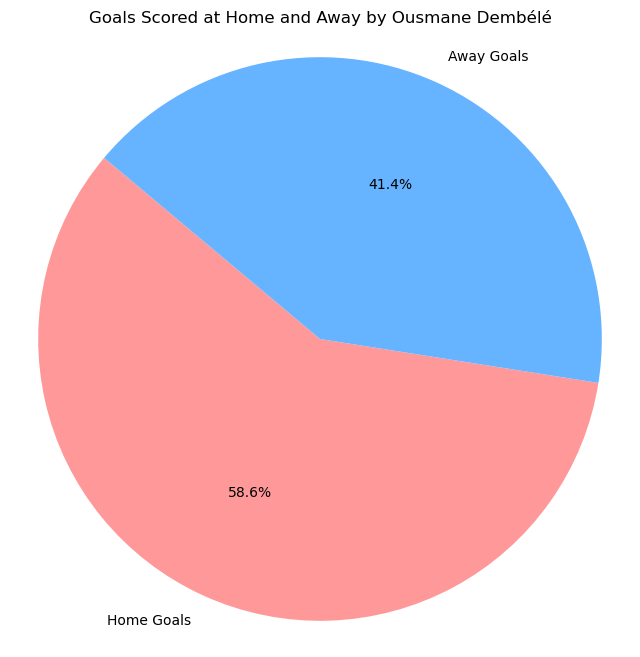

In [53]:
def plot_home_away_goals(player_id):
    # Query to get goals scored at home and away by the player
    query = f"""
    SELECT 
        SUM(CASE WHEN g.home_club_id = a.player_club_id THEN a.goals ELSE 0 END) AS home_goals,
        SUM(CASE WHEN g.away_club_id = a.player_club_id THEN a.goals ELSE 0 END) AS away_goals
    FROM Appearances a
    JOIN Games g ON a.game_id = g.game_id
    WHERE a.player_id = {player_id};
    """
    
    # Execute the query and load the data into a DataFrame
    df = pd.read_sql_query(query, engine)
    
    # Query to get the player's full name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    
    # Execute the query and get the player's full name
    name_df = pd.read_sql_query(name_query, engine)
    player_name = name_df['name'].iloc[0]
    
    # Data for the pie chart
    labels = ['Home Goals', 'Away Goals']
    sizes = [df['home_goals'].iloc[0], df['away_goals'].iloc[0]]
    colors = ['#ff9999','#66b3ff']
    
    # Create the pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.title(f'Goals Scored at Home and Away by {player_name}')
    plt.show()

#plot_home_away_goals(player_id=288230)

# Clubs analysis function

# Pie chart of club's wins losses and draws in a specific season

In [63]:
def plot_club_wins_draws_losses_season(club_id, season):
    # Query to get wins, draws, and losses for the club in a specific season
    query = f"""
    SELECT 
        SUM(CASE WHEN (home_club_id = {club_id} AND home_club_goals > away_club_goals) OR (away_club_id = {club_id} AND away_club_goals > home_club_goals) THEN 1 ELSE 0 END) AS wins,
        SUM(CASE WHEN home_club_goals = away_club_goals THEN 1 ELSE 0 END) AS draws,
        SUM(CASE WHEN (home_club_id = {club_id} AND home_club_goals < away_club_goals) OR (away_club_id = {club_id} AND away_club_goals < home_club_goals) THEN 1 ELSE 0 END) AS losses
    FROM Games
    WHERE (home_club_id = {club_id} OR away_club_id = {club_id}) AND season = '{season}';
    """
    
    # Execute the query and load the data into a DataFrame
    df = pd.read_sql_query(query, engine)
    
    # Query to get the club's name
    name_query = f"""
    SELECT name
    FROM Clubs
    WHERE club_id = {club_id};
    """
    
    # Execute the query and get the club's name
    name_df = pd.read_sql_query(name_query, engine)
    club_name = name_df['name'].iloc[0]
    
    # Data for the pie chart
    labels = ['Wins', 'Draws', 'Losses']
    sizes = [df['wins'].iloc[0], df['draws'].iloc[0], df['losses'].iloc[0]]
    colors = ['#66b3ff', '#ffcc99', '#ff9999']
    
    # Create the pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  # we're making sure the graph is a circle
    
    plt.title(f'Wins, Draws, and Losses for {club_name} in {season}')
    plt.show()


#plot_club_wins_draws_losses_season(club_id=12, season='2022')

# Line chart displaying wins, draws, losses of a club between 2 seasons

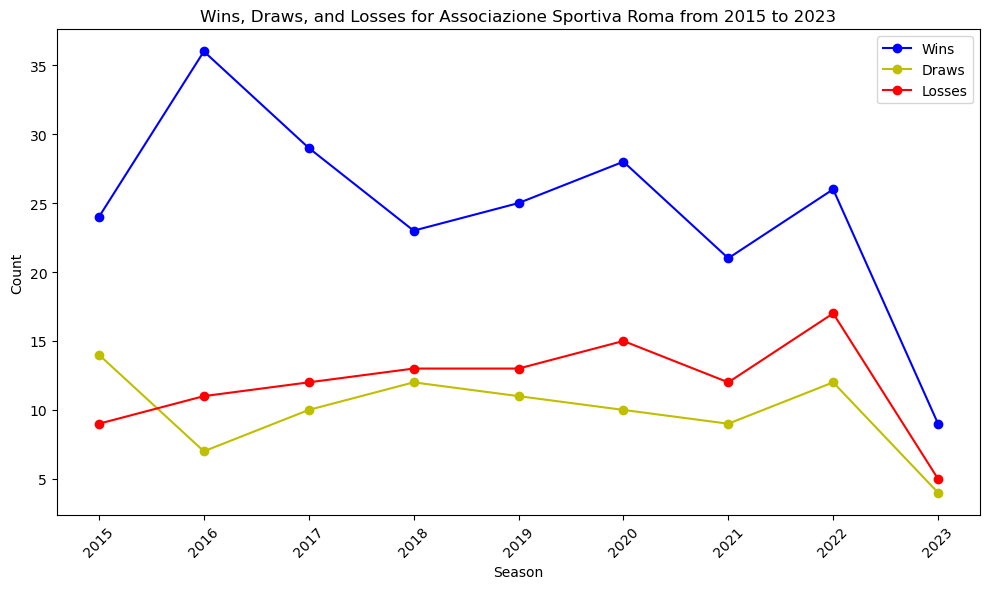

In [68]:
def plot_club_wins_draws_losses_seasons(club_id, season_start, season_end):
    # Query to get wins, draws, and losses for the club across the specified seasons
    query = f"""
    SELECT 
        g.season,
        SUM(CASE WHEN (g.home_club_id = {club_id} AND g.home_club_goals > g.away_club_goals) OR (g.away_club_id = {club_id} AND g.away_club_goals > g.home_club_goals) THEN 1 ELSE 0 END) AS wins,
        SUM(CASE WHEN g.home_club_goals = g.away_club_goals THEN 1 ELSE 0 END) AS draws,
        SUM(CASE WHEN (g.home_club_id = {club_id} AND g.home_club_goals < g.away_club_goals) OR (g.away_club_id = {club_id} AND g.away_club_goals < g.home_club_goals) THEN 1 ELSE 0 END) AS losses
    FROM Games g
    WHERE (g.home_club_id = {club_id} OR g.away_club_id = {club_id}) AND g.season BETWEEN '{season_start}' AND '{season_end}'
    GROUP BY g.season
    ORDER BY g.season;
    """
    
    # Execute the query and load the data into a DataFrame
    df = pd.read_sql_query(query, engine)
    
    # Query to get the club's name
    name_query = f"""
    SELECT name
    FROM Clubs
    WHERE club_id = {club_id};
    """
    
    name_df = pd.read_sql_query(name_query, engine)
    club_name = name_df['name'].iloc[0]
    
    # Create the line plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df['season'] = df['season'].astype(str)  
    
    ax.plot(df['season'], df['wins'], marker='o', linestyle='-', color='b', label='Wins')
    ax.plot(df['season'], df['draws'], marker='o', linestyle='-', color='y', label='Draws')
    ax.plot(df['season'], df['losses'], marker='o', linestyle='-', color='r', label='Losses')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Count')
    ax.set_title(f'Wins, Draws, and Losses for {club_name} from {season_start} to {season_end}')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_club_wins_draws_losses_seasons(club_id=12, season_start='2015', season_end='2023')

# Total goals scored and conceded per season by a club

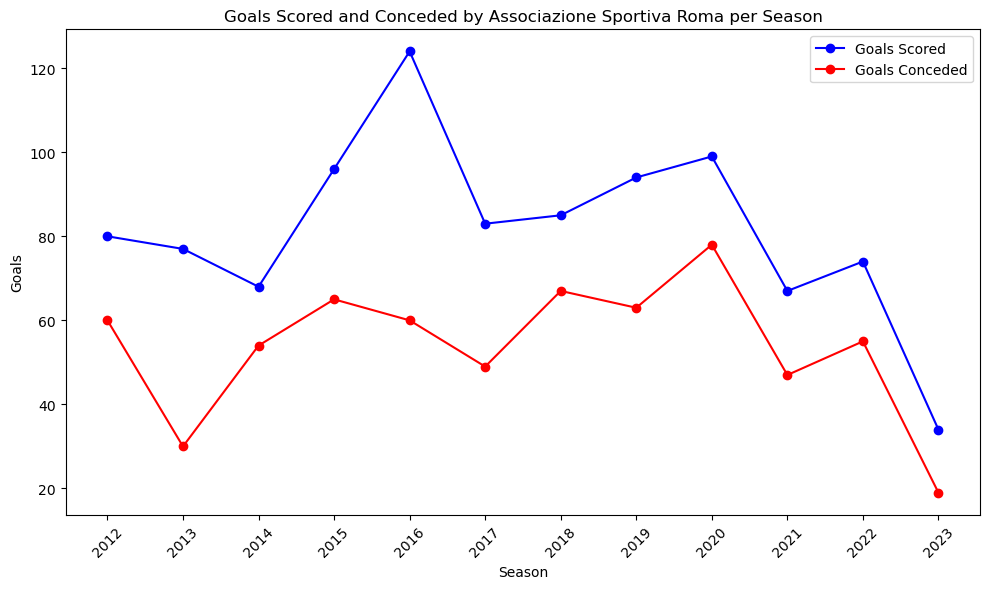

In [74]:
def plot_goals_scored_conceded_season(club_id):
    query = f"""
    SELECT 
        g.season,
        SUM(CASE WHEN g.home_club_id = {club_id} THEN g.home_club_goals ELSE g.away_club_goals END) AS goals_scored,
        SUM(CASE WHEN g.home_club_id = {club_id} THEN g.away_club_goals ELSE g.home_club_goals END) AS goals_conceded
    FROM Games g
    WHERE g.home_club_id = {club_id} OR g.away_club_id = {club_id}
    GROUP BY g.season
    ORDER BY g.season;
    """
    
    df = pd.read_sql_query(query, engine)
    
    name_query = f"""
    SELECT name
    FROM Clubs
    WHERE club_id = {club_id};
    """
    name_df = pd.read_sql_query(name_query, engine)
    club_name = name_df['name'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    df['season'] = df['season'].astype(str)
    
    ax.plot(df['season'], df['goals_scored'], marker='o', linestyle='-', color='b', label='Goals Scored')
    ax.plot(df['season'], df['goals_conceded'], marker='o', linestyle='-', color='r', label='Goals Conceded')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    ax.set_title(f'Goals Scored and Conceded by {club_name} per Season')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
plot_goals_scored_conceded_season(club_id=12)


# Home vs away performance of a club in a season

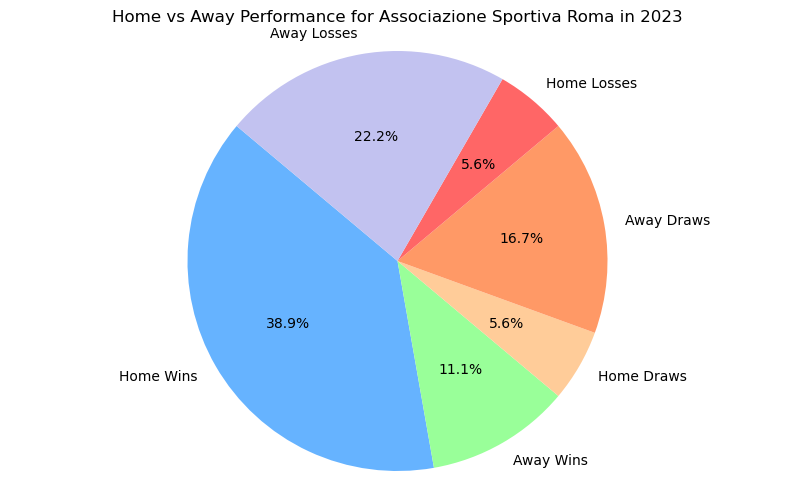

In [78]:
def plot_home_away_performance_season(club_id, season):
    # Query to get home and away performance for the club in a specific season
    query = f"""
    SELECT 
        SUM(CASE WHEN g.home_club_id = {club_id} AND g.home_club_goals > g.away_club_goals THEN 1 ELSE 0 END) AS home_wins,
        SUM(CASE WHEN g.away_club_id = {club_id} AND g.away_club_goals > g.home_club_goals THEN 1 ELSE 0 END) AS away_wins,
        SUM(CASE WHEN g.home_club_id = {club_id} AND g.home_club_goals < g.away_club_goals THEN 1 ELSE 0 END) AS home_losses,
        SUM(CASE WHEN g.away_club_id = {club_id} AND g.away_club_goals < g.home_club_goals THEN 1 ELSE 0 END) AS away_losses,
        SUM(CASE WHEN g.home_club_id = {club_id} AND g.home_club_goals = g.away_club_goals THEN 1 ELSE 0 END) AS home_draws,
        SUM(CASE WHEN g.away_club_id = {club_id} AND g.home_club_goals = g.away_club_goals THEN 1 ELSE 0 END) AS away_draws
    FROM Games g
    WHERE (g.home_club_id = {club_id} OR g.away_club_id = {club_id}) AND g.season = '{season}';
    """
    
    # Execute the query and load the data into a DataFrame
    df = pd.read_sql_query(query, engine)
    
    # Query to get the club's name
    name_query = f"""
    SELECT name
    FROM Clubs
    WHERE club_id = {club_id};
    """
    
    # Execute the query and get the club's name
    name_df = pd.read_sql_query(name_query, engine)
    club_name = name_df['name'].iloc[0]
    
    # Data for the pie chart
    labels = ['Home Wins', 'Away Wins', 'Home Draws', 'Away Draws', 'Home Losses', 'Away Losses']
    sizes = [
        df['home_wins'].iloc[0], df['away_wins'].iloc[0],
        df['home_draws'].iloc[0], df['away_draws'].iloc[0],
        df['home_losses'].iloc[0], df['away_losses'].iloc[0]
    ]
    colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9966', '#ff6666', '#c2c2f0']
    
    # Create the pie chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')
    
    plt.title(f'Home vs Away Performance for {club_name} in {season}')
    plt.show()

# Example usage
plot_home_away_performance_season(club_id=12, season='2023')